# Optimization Tutorial

Trey V. Wenger (c) October 2024

Here we demonstrate how to optimize the number of cloud components in a `bayes_spec` model.

In [12]:
# General imports    
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.0-staging+1.g67d2c18.dirty


## Model Definition and Simulated Data

Like in the basic tutorial for `GaussNoiseModel`, our model is a Gaussian line profile with the spectral noise as a free parameter. We generate synthetic data as in the basic tutorial, and the data key must be `"observation"` for this model.

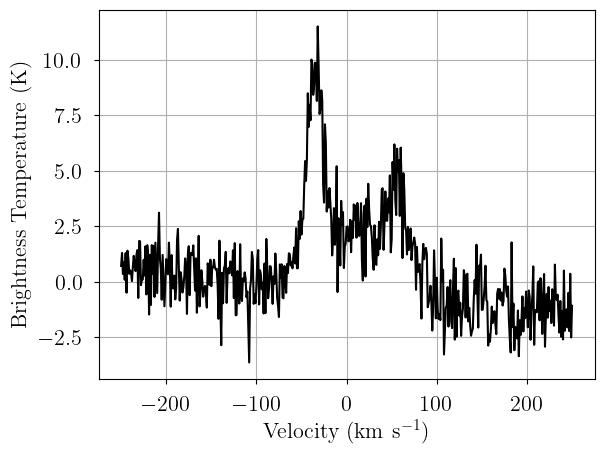

In [13]:
from bayes_spec import SpecData
from bayes_spec.models import GaussNoiseModel

# Generate dummy data format for simulation
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s
noise = 1.0 # K
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "baseline_observation_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [14]:
# Pack simulated data into SpecData
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## `Optimize`

We use the `Optimize` class for optimization.

In [15]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    GaussNoiseModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=2,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [16]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model, and is then sampled with MCMC.

In [17]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs)

Null hypothesis BIC = 2.993e+03
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 2300
Interrupted at 2,299 [2%]: Average Loss = 1,114.9


Output()

n_cloud = 1 BIC = 1.986e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 1,043.1


Output()

n_cloud = 2 BIC = 1.613e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 3900
Interrupted at 3,899 [3%]: Average Loss = 1,143


Output()

n_cloud = 3 BIC = 1.575e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 2000
Interrupted at 1,999 [1%]: Average Loss = 1,537.8


Output()

n_cloud = 4 BIC = 2.066e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 4400
Interrupted at 4,399 [4%]: Average Loss = 1,137.7


Output()

n_cloud = 5 BIC = 1.618e+03

Sampling best model (n_cloud = 3)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3900
Interrupted at 3,899 [3%]: Average Loss = 1,143
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution


The "best" model is saved in `opt.best_model`.

In [18]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],8.592,0.442,7.794,9.475,0.010,0.008,1943.0,1423.0,1.0
amplitude[1],3.552,0.468,2.694,4.474,0.013,0.010,1319.0,1158.0,1.0
amplitude[2],2.893,0.216,2.490,3.296,0.004,0.003,2941.0,3359.0,1.0
baseline_observation_norm[0],-0.511,0.052,-0.607,-0.410,0.001,0.001,1825.0,2668.0,1.0
baseline_observation_norm[1],-0.854,0.073,-0.987,-0.717,0.001,0.001,4177.0,3059.0,1.0
baseline_observation_norm[2],0.606,0.731,-0.742,1.993,0.016,0.011,2062.0,2368.0,1.0
fwhm[0],21.083,1.385,18.418,23.598,0.034,0.025,1711.0,1522.0,1.0
fwhm[1],27.249,5.167,17.991,36.907,0.145,0.103,1299.0,2191.0,1.0
fwhm[2],92.332,14.833,63.343,117.720,0.535,0.379,1029.0,612.0,1.0
fwhm_norm[0],0.703,0.046,0.614,0.787,0.001,0.001,1711.0,1522.0,1.0


With `approx=False`, the optimization algorithm samples each model with MCMC (or SMC if `smc=True`) and determines which is the first model with a BIC within `bic_threshold` of the minimum across all models. This is more accurate, but slower. Be careful not to set `max_n_clouds` too high!

In [19]:
opt.optimize(sample_kwargs=sample_kwargs, approx=False)

Null hypothesis BIC = 2.993e+03
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2300
Interrupted at 2,299 [2%]: Average Loss = 1,114.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 1.981e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 1,043.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.610e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3900
Interrupted at 3,899 [3%]: Average Loss = 1,143
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 1.566e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2000
Interrupted at 1,999 [1%]: Average Loss = 1,537.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


Adding log-likelihood to trace


Output()

There were 33 divergences in converged chains.
No solution found!
0 of 4 chains appear converged.

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4400
Interrupted at 4,399 [4%]: Average Loss = 1,137.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 76 seconds.


Adding log-likelihood to trace


Output()

There were 21 divergences in converged chains.
No solution found!
0 of 4 chains appear converged.



Notice that models with more complexity than is present in the data (i.e., `n_clouds` > the true number of clouds) tend to have more divergences and difficulty converging.

In [20]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],8.592,0.442,7.794,9.475,0.010,0.008,1943.0,1423.0,1.0
amplitude[1],3.552,0.468,2.694,4.474,0.013,0.010,1319.0,1158.0,1.0
amplitude[2],2.893,0.216,2.490,3.296,0.004,0.003,2941.0,3359.0,1.0
baseline_observation_norm[0],-0.511,0.052,-0.607,-0.410,0.001,0.001,1825.0,2668.0,1.0
baseline_observation_norm[1],-0.854,0.073,-0.987,-0.717,0.001,0.001,4177.0,3059.0,1.0
baseline_observation_norm[2],0.606,0.731,-0.742,1.993,0.016,0.011,2062.0,2368.0,1.0
fwhm[0],21.083,1.385,18.418,23.598,0.034,0.025,1711.0,1522.0,1.0
fwhm[1],27.249,5.167,17.991,36.907,0.145,0.103,1299.0,2191.0,1.0
fwhm[2],92.332,14.833,63.343,117.720,0.535,0.379,1029.0,612.0,1.0
fwhm_norm[0],0.703,0.046,0.614,0.787,0.001,0.001,1711.0,1522.0,1.0


With posteriors sampled with MCMC, we can also use leave-one-out cross-validation to perform model comparison.

In [21]:
# leave-one-out cross validation
loo = az.compare({
    n_gauss: model.trace for n_gauss, model in opt.models.items()
    if model.solutions # ignore models with no valid solutions
})
loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
3,0,-749.754129,13.759484,0.000000,0.875699,15.449865,0.000000,False,log
2,1,-779.374082,10.868164,29.619954,0.124301,16.802132,9.771588,False,log
1,2,-973.238546,8.968268,223.484417,0.000000,25.460147,25.614533,False,log


The model with the largest `elpd_loo` is preferred.